In [1]:
import warnings
warnings.filterwarnings('ignore')
# import cv2
import numpy as np
import glob
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
from keras.models import load_model
import segmentation_models as sm

seed = 56

IMAGE_HEIGHT = IMAGE_WIDTH = 256 * 2 # * 2

BATCH_SIZE = 4

ROOT = "./../Data/all-cities/"
TEST_DIR = "_Test512/"

Segmentation Models: using `keras` framework.


In [2]:
from PIL import Image

test_images = np.array([np.array(Image.open(fname)) for fname in glob.glob(ROOT + TEST_DIR + 'Images/samples/*')])
test_masks = np.array([np.array(Image.open(fname).convert('L')) for fname in glob.glob(ROOT + TEST_DIR + 'Masks/samples/*')]) # convert to lose two channels


In [3]:
import get_data_generators

augmentation = {
}

test_gen = get_data_generators.getDataGenerators(augmentation, (IMAGE_WIDTH, IMAGE_HEIGHT), test_images_path=ROOT + TEST_DIR + "Images", test_targets_path=ROOT + TEST_DIR + "Masks", batch_size=BATCH_SIZE, seed=seed)
test_gen = test_gen[0]

Found 1771 images belonging to 1 classes.
Found 1771 images belonging to 1 classes.


In [12]:
import metric

model_path = "./../Models/Double-Data/backbones/bike_mapper_pre-train-scratch-densenet121_Aug_IoU3076_q6178.h5"
modelEval = load_model(model_path, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.1), "f1-score":sm.metrics.FScore(), "quality": metric.quality()})

met = modelEval.metrics[1:] #+ [metric.quality()] # [1:] to not include loss

modelEval.compile(optimizer=modelEval.optimizer, loss=modelEval.loss, metrics= met, run_eagerly=True)

In [6]:
modelEval.evaluate(test_gen.data, steps=test_gen.samplesPerBatch)

1269/1269 [==============================] - 230s 176ms/step - loss: 0.2482 - iou_score: 0.6075 - f1-score: 0.7518 - quality: 0.8080


[0.24821749329566956,
 0.6074666380882263,
 0.7518056035041809,
 0.8080042600631714]

In [3]:
predictions = modelEval.predict(test_gen.data, steps=test_gen.samplesPerBatch)

NameError: name 'test_gen' is not defined

1/1 [==============================] - 1s 970ms/step
[  0 128 255]


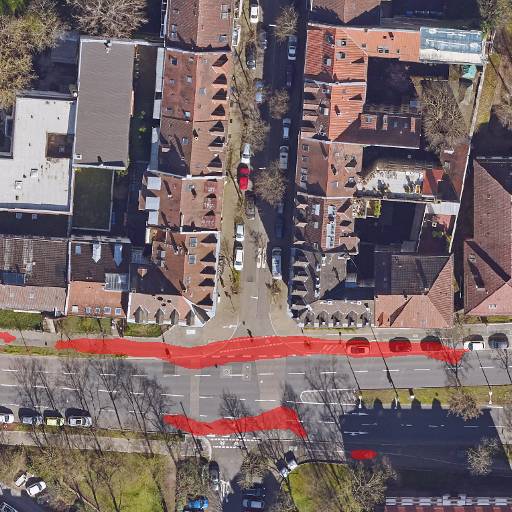

In [13]:
import inference

pred = inference.predict_overlay(modelEval, 'C:/Users/domin/Desktop/test-karlsruhe.tif')
display(pred.convert("RGB"))
# "C:/Users/domin/Desktop/gitrepos/detector/Data/Hannover/_Test512/Images/samples/14_dop20rgb_32_546_5800_2_ni_2019-04-08.tif")

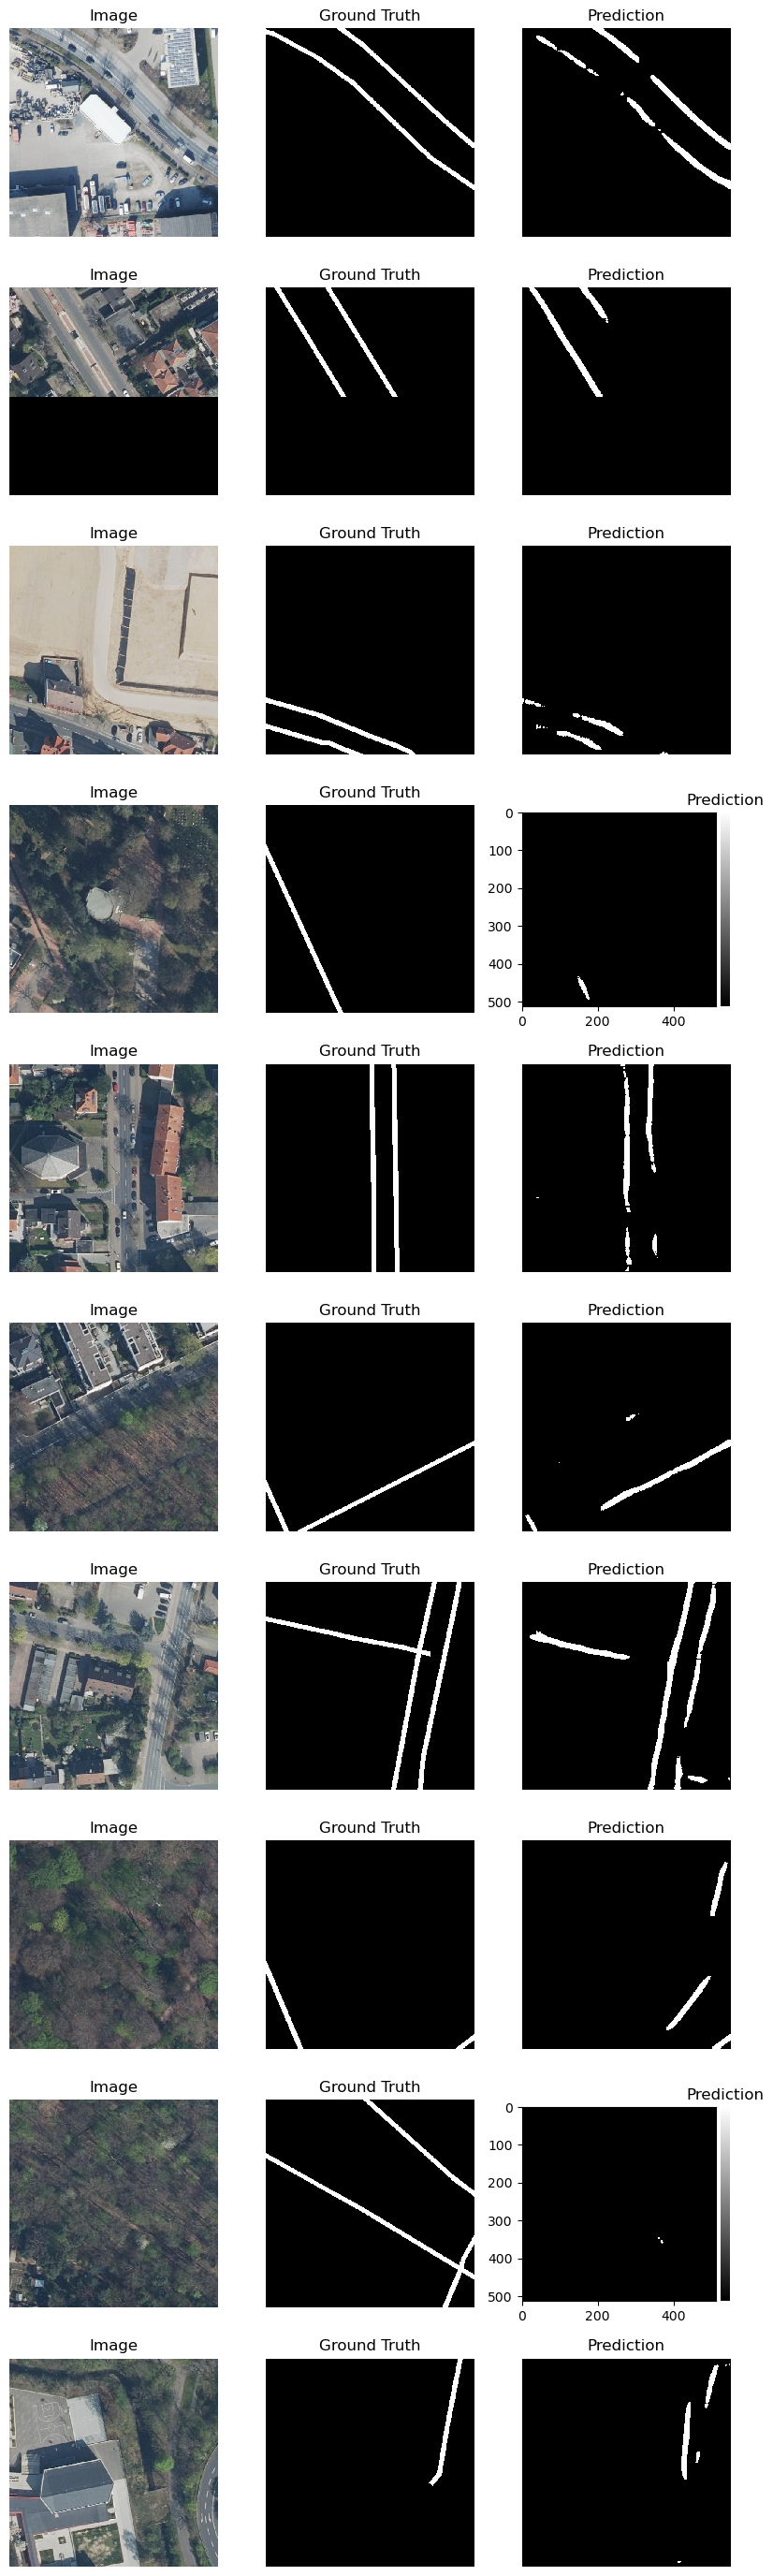

In [6]:
thresh_val = 0.1

ix = random.randint(0, len(predictions))
num_samples = 10

f = plt.figure(figsize = (8, 28))
for i in range(1, num_samples*3, 3):
  ix = random.randint(0, len(predictions))

  f.add_subplot(num_samples, 3, i)
  imshow(test_images[ix][:,:,:])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+1)
  show = np.squeeze(test_masks[ix][:,:])
  imshow(show)
  plt.title("Ground Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+2)
  show = np.squeeze(predictions[ix][:,:,0])
  show[show < thresh_val] = 0
  show[show >= thresh_val] = 255
  show = show.astype(np.uint8)
  imshow(show, cmap="gray")
  plt.title("Prediction")
  plt.axis('off')

plt.show()

In [4]:
# test all in directory

import metric
import os

models_files = glob.glob("./../Models/Double-Data/road-pre-trained-backbones/*.h5") #+ glob.glob("./../Models/Double-Data/*.h5")
models = []

for model_path in models_files:
  if model_path[-4].isdigit():
    continue

  models.append(model_path)

print("networks to be tested:")
print(models)

for model_path in models:
  print("testing", model_path)

  modelEval = load_model(model_path, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.1), "f1-score":sm.metrics.FScore(), "quality": metric.quality()})

  met = modelEval.metrics[1:] #+ [metric.quality()] # [1:] to not include loss

  modelEval.compile(optimizer=modelEval.optimizer, loss=modelEval.loss, metrics= met, run_eagerly=True)

  _, iou, _, quality = modelEval.evaluate(test_gen.data, steps=test_gen.samplesPerBatch)

  iou, quality = round(iou * 10_000), round(quality * 10_000)

  insertion = "_IoU" + str(iou) + "_q" + str(quality)
  os.rename(model_path, model_path[:-3] + insertion + ".h5")
  os.rename(model_path[:-3] + "__iou.png", model_path[:-3] + insertion + "__iou.png")
  os.rename(model_path[:-3] + "__quality.png", model_path[:-3] + insertion + "__quality.png")


networks to be tested:
['./../Models/Double-Data/road-pre-trained-backbones\\bike_mapper_pre-train-densenet121freeze-left_Aug.h5', './../Models/Double-Data/road-pre-trained-backbones\\bike_mapper_pre-train-densenet121freeze-right_Aug.h5', './../Models/Double-Data/road-pre-trained-backbones\\bike_mapper_pre-train-efficientnetb2freeze-left_Aug.h5', './../Models/Double-Data/road-pre-trained-backbones\\bike_mapper_pre-train-efficientnetb2freeze-right_Aug.h5', './../Models/Double-Data/road-pre-trained-backbones\\bike_mapper_pre-train-resnet34freeze-left_Aug.h5', './../Models/Double-Data/road-pre-trained-backbones\\bike_mapper_pre-train-resnet34freeze-right_Aug.h5', './../Models/Double-Data/road-pre-trained-backbones\\bike_mapper_pre-train-vgg16freeze-left_Aug.h5', './../Models/Double-Data/road-pre-trained-backbones\\bike_mapper_pre-train-vgg16freeze-right_Aug.h5']
testing ./../Models/Double-Data/road-pre-trained-backbones\bike_mapper_pre-train-densenet121freeze-left_Aug.h5
442/442 [========